## 📚 Importing Libraries

In [97]:
# import libraries
import pandas as pd
import numpy as np
import os
import ray
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from transformers import BertTokenizer
import random
import torch
import torch.nn as nn
from transformers import BertModel
from ray.data.preprocessor import Preprocessor
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer, TorchConfig, TorchPredictor
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel
from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore")


## 🛠️ Setup

In [2]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-08-19 15:38:41,710	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.18
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


(TorchTrainer pid=24048) Starting distributed worker processes: ['18760 (127.0.0.1)']
(RayTrainWorker pid=18760) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=18760) [W ..\torch\csrc\distributed\c10d\socket.cpp:601] [c10d] The client socket has failed to connect to [kubernetes.docker.internal]:51939 (system error: 10049 - The requested address is not valid in its context.).
(RayTrainWorker pid=18760) [W ..\torch\csrc\distributed\c10d\socket.cpp:601] [c10d] The client socket has failed to connect to [kubernetes.docker.internal]:51939 (system error: 10049 - The requested address is not valid in its context.).
(RayTrainWorker pid=18760) C:\Users\sara\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=18760)   warnings

In [3]:
ray.cluster_resources()

{'object_store_memory': 263405568.0,
 'memory': 526811136.0,
 'node:127.0.0.1': 1.0,
 'GPU': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 12.0}

In [4]:
num_workers = 1 
resources_per_worker={"CPU": 2, "GPU": 1}  



In [5]:
load_dotenv()
LOCAL_DIR = os.path.expanduser(f"~/ray_results/{os.getenv('GITHUB_USERNAME')}")
os.makedirs(LOCAL_DIR, exist_ok=True)
print("Storage path:", LOCAL_DIR)


Storage path: C:\Users\sara/ray_results/sara12312


## 📥 Data Ingestion

In [6]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [7]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

## ✂️ Data Splitting

In [8]:
# Split dataset
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=0.2, random_state=42)


In [9]:
# Train value counts
train_df.tag.value_counts()


tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [10]:
# Validation (adjusted) value counts
val_df.tag.value_counts()* int((1-0.2) / 0.2)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 📊 Exploratory Data Analysis (EDA)

In [11]:
# check most common tags
df.tag.value_counts()


tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [12]:
# Check nulls
df.isnull().sum()

id             0
created_on     0
title          0
description    0
tag            0
dtype: int64

In [13]:
# Check duplicates
df.duplicated().sum()

0

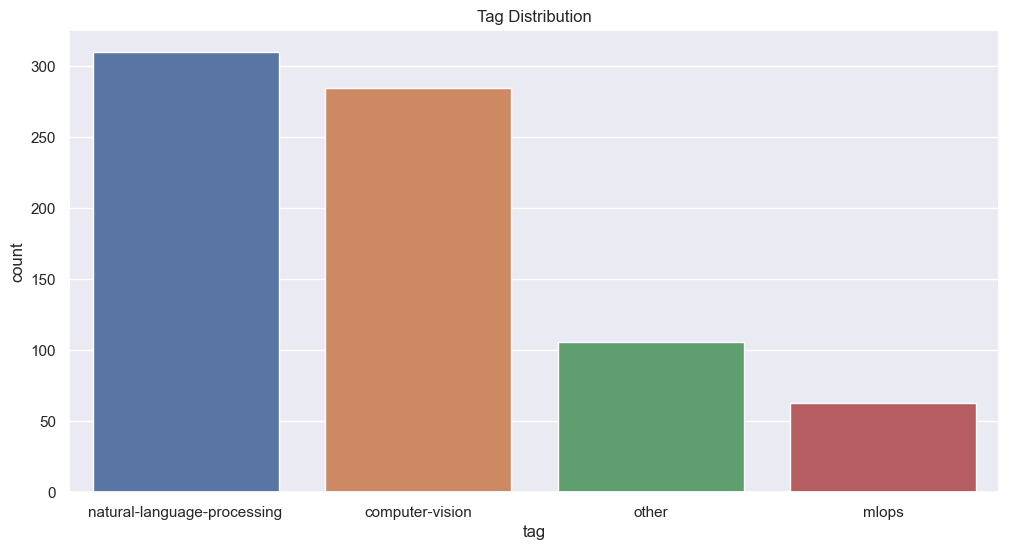

In [14]:
# plot tag distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='tag', order=df['tag'].value_counts().index)
plt.title('Tag Distribution')
plt.xticks()
plt.show()


In [15]:
# Most frequent tokens for each tag 
def show_wordcloud(tag):
    text = " ".join(df[df["tag"] == tag]["title"].astype(str) + " " +
                    df[df["tag"] == tag]["description"].astype(str))
    
    wc = WordCloud(width=800, height=400, background_color="black", mode="RGB").generate(text)
    
    fig, ax = plt.subplots(figsize=(10, 5), facecolor="black")
    ax.imshow(wc, interpolation="bilinear")
    ax.set_facecolor("black")  # Axes background
    ax.axis("off")
    ax.set_title(f"Word Cloud for tag: {tag}", fontsize=16, color="white")
    
    # Force black canvas when saving or rendering
    fig.patch.set_facecolor("black")
    plt.tight_layout(pad=0)
    plt.show()

# Create dropdown with unique tags
tags = df["tag"].unique()
interact(show_wordcloud, tag=Dropdown(options=tags, description="Select Tag:"))

interactive(children=(Dropdown(description='Select Tag:', options=('computer-vision', 'other', 'natural-langua…

<function __main__.show_wordcloud(tag)>

## ✨ Data Preprocessing

### Feature Engineering

In [16]:
# combine title and description
df['text'] = (df["title"] + " " + df["description"])

### Cleaning

In [17]:
# Download NLTK stopwords
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# text cleaning
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [19]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [20]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label Encoding

In [21]:
#  Convert column to categorical
df['tag'] = df['tag'].astype('category')

#  Save the mapping
index_to_class = dict(enumerate(df['tag'].cat.categories))
class_to_index = {v: k for k, v in index_to_class.items()}

print("Class_to_index:", class_to_index)
print("Index to class:", index_to_class)

#  Replace column with codes
df['tag'] = df['tag'].cat.codes

# Decode function
def decode(indices, index_to_class=index_to_class):
    """Convert numeric predictions back to class labels."""
    return [index_to_class[i] for i in indices]

Class_to_index: {'computer-vision': 0, 'mlops': 1, 'natural-language-processing': 2, 'other': 3}
Index to class: {0: 'computer-vision', 1: 'mlops', 2: 'natural-language-processing', 3: 'other'}


In [22]:
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,0
1,show infer tell contextual inference creative ...,0
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [23]:
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer


In [24]:
# Bert tokenizer
Tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

# Tokenize batches of data
def tokenize(batch):
    tokenizer = Tokenizer
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [25]:
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0], dtype=int8)}

Combine preprocessing into one function

In [26]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [27]:
# Apply
preprocess(df=train_df, class_to_index= class_to_index)

{'ids': array([[  102,  6828,  1630, ...,     0,     0,     0],
        [  102,  2570,  7885, ...,     0,     0,     0],
        [  102,  8854,  2998, ...,     0,     0,     0],
        ...,
        [  102,  3526,   318, ...,     0,     0,     0],
        [  102,  1387, 30110, ...,     0,     0,     0],
        [  102, 10850,   142, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([2, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 2, 0, 3, 3, 0, 1, 0, 3, 2, 0, 0,
        2, 1, 3, 1, 2, 2, 0, 2, 3, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0,
        3, 0, 2, 3, 1, 2, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 0,
        2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 3, 2, 2, 1, 0, 3, 2, 2, 2,
        0, 0, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 3, 3, 3, 0, 2, 2, 0, 3, 0, 1,
        2, 0, 2, 0, 2, 2, 1, 2, 3

## 🌐 Distributed Preprocessing

Performing data processing but in a distributed manner using Ray.

In [28]:
# setup
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [29]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=42)
ds.take(1)

2025-08-19 15:39:05,398	INFO read_api.py:406 -- To satisfy the requested parallelism of 24, each read task output is split into 24 smaller blocks.
2025-08-19 15:39:05,447	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-08-19 15:39:05,453	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-08-19 15:39:05,454	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:05,454	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 653,
  'created_on': datetime.datetime(2020, 4, 28, 16, 20, 29),
  'title': 'Semantic Graphs for Generating Deep Questions',
  'description': 'Deep Question Generation (DQG), which aims to generate complex questions that require reasoning over multiple pieces of information of the input passage. ',
  'tag': 'natural-language-processing'}]

In [30]:
%cd ..

c:\Users\sara\MadeWithML


In [31]:
# split dataset
from src import stratify_split

test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-08-19 15:39:08,760	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-08-19 15:39:08,766	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:08,766	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
train_ds

RandomShuffle
+- MapBatches(_filter_train)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=24,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

In [33]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2025-08-19 15:39:12,040	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> LimitOperator[limit=1]
2025-08-19 15:39:12,040	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:12,040	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:39:17,521	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-08-19 15:39:17,532	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:17,537	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [34]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
    preprocess,
    fn_kwargs={"class_to_index": class_to_index},
    batch_format="pandas")
sample_ds.show(1)

2025-08-19 15:39:19,258	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2025-08-19 15:39:19,260	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:19,260	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

{'ids': array([  102, 17007,   160,   239, 30118,  1313,  4744,  1995, 17007,
         160, 23907,  5702,  2112,   255,   239, 30118,  2567,  1995,
        1313,  4744,   103,     0,     0,     0,     0,     0,     0,
           0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0]), 'targets': 0}


Functions for reproducibility

In [35]:
# set seeds
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [36]:
# load data
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [37]:
# preprocessor
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

## 🤖 Model

In [38]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
embedding_dim

768

In [40]:
# Fine-tuning the LLM
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [41]:
# Initialize model
num_classes=4
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦 Batching

In [42]:
from ray.train.torch import get_device

padding training batches

In [43]:
# Function to pad sequences to the same length
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [44]:
# Function to collate padded batches into tensors
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [45]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2025-08-19 15:39:25,636	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2025-08-19 15:39:25,640	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:25,641	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

{'ids': tensor([[  102, 17755,   919,  ...,     0,     0,     0],
         [  102,  3997,  1904,  ...,     0,     0,     0],
         [  102,  3577,   791,  ...,     0,     0,     0],
         ...,
         [  102,  4631, 22938,  ...,     0,     0,     0],
         [  102,   760,  1391,  ...,     0,     0,     0],
         [  102, 16337,  5712,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 3, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 3, 3, 2, 3, 2, 0,
         1, 2, 2, 0, 1, 2, 0, 3, 2, 1, 2, 0, 3, 0, 0, 2, 2, 0, 0, 2, 2, 3, 2, 3,
         2, 0, 1, 2, 2, 0, 0, 2, 0, 3, 2, 0, 2, 0, 3, 0, 0, 2, 2, 0, 0, 2, 2, 3,
         2, 3, 0, 2, 2, 2, 0, 0, 3, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2,
         0, 3, 

## 🧮 Utilities

In [46]:
# Training step
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [47]:
# Evaluation step
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [48]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

## 🗂️ Configurations

In [49]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [50]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [51]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
# Fix RunConfig with proper storage path
run_config = RunConfig(
    name="llm",
    checkpoint_config=checkpoint_config,
    local_dir=os.path.expanduser("~/ray_results"),  
    verbose=1
)

## 🚂 Training

In [52]:
# Load and split data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-08-19 15:39:28,222	INFO read_api.py:406 -- To satisfy the requested parallelism of 24, each read task output is split into 24 smaller blocks.
2025-08-19 15:39:28,238	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-08-19 15:39:28,238	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:28,238	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2025-08-19 15:39:28,992	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> LimitOperator[limit=1]
2025-08-19 15:39:28,992	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:28,992	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:39:30,293	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-08-19 15:39:30,296	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:30,297	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:39:32,180	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-08-19 15:39:32,181	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:32,182	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_train)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:39:34,120	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_test)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-08-19 15:39:34,121	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 15:39:34,123	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_test)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [54]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options
    )

In [55]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    torch_config=TorchConfig(backend="gloo"),
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [56]:
%%time
# Train
results = trainer.fit()

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:41:06,346	WARNING util.py:315 -- The `on_step_begin` operation took 0.875 s, which may be a performance bottleneck.
2025-08-19 15:41:50,323	WARNING util.py:315 -- The `on_step_begin` operation took 0.607 s, which may be a performance bottleneck.
2025-08-19 15:43:43,198	WARNING util.py:315 -- The `on_step_begin` operation took 0.551 s, which may be a performance bottleneck.
2025-08-19 15:44:27,085	WARNING util.py:315 -- The `on_step_begin` operation took 0.754 s, which may be a performance bottleneck.
2025-08-19 15:45:56,610	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_interna

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:46:06,133	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2025-08-19 15:46:18,603	WARNING util.py:315 -- The `on_step_begin` operation took 0.508 s, which may be a performance bottleneck.
2025-08-19 15:48:57,579	WARNING util.py:315 -- The `on_step_begin` operation took 2.089 s, which may be a performance bottleneck.
2025-08-19 15:50:42,066	WARNING util.py:315 -- The `on_step_begin` operation took 1.221 s, which may be a performance bottleneck.
2025-08-19 15:50:51,617	WARNING util.py:315 -- Th

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:52:21,127	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 15:52:54,768	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 528, in wait
    self._sync_process.wait(timeout=self.sync_timeout)
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 203, in wait
    raise exception
  File "c:\Users\s

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 15:57:58,917	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 15:58:09,439	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 528, in wait
    self._sync_process.wait(timeout=self.sync_timeout)
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 203, in wait
    raise exception
  File "c:\Users\s

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 16:04:19,627	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 16:04:30,580	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 528, in wait
    self._sync_process.wait(timeout=self.sync_timeout)
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 203, in wait
    raise exception
  File "c:\Users\s

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 16:18:38,890	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 16:19:33,514	WARNING util.py:315 -- The `on_step_begin` operation took 10.963 s, which may be a performance bottleneck.
2025-08-19 16:19:44,939	WARNING util.py:315 -- The `on_step_begin` operation took 0.875 s, which may be a performance bottleneck.
2025-08-19 16:22:31,151	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-pa

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 16:24:58,751	WARNING util.py:315 -- The `on_step_begin` operation took 0.850 s, which may be a performance bottleneck.
2025-08-19 16:25:31,904	WARNING util.py:315 -- The `on_step_begin` operation took 0.924 s, which may be a performance bottleneck.


(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 16:29:12,819	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 16:29:23,333	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 528, in wait
    self._sync_process.wait(timeout=self.sync_timeout)
  File "c:\Users\sara\miniconda3\envs\mwml\lib\site-packages\ray\train\_internal\syncer.py", line 203, in wait
    raise exception
  File "c:\Users\s

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 16:34:52,018	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 16:34:52,026	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2025-08-19 16:35:03,591	WARNING util.py:315 -- The `on_step_begin` operation took 0.888 s, which may be a performance bottleneck.
2025-08-19 16:38:03,418	W

(pid=3308) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 16:41:56,094	WARNING util.py:315 -- The `on_step_begin` operation took 1.984 s, which may be a performance bottleneck.
2025-08-19 16:42:08,021	WARNING util.py:315 -- The `callbacks.on_step_begin` operation took 0.702 s, which may be a performance bottleneck.
2025-08-19 16:44:03,898	WARNING util.py:315 -- The `on_step_begin` operation took 3.137 s, which may be a performance bottleneck.
2025-08-19 16:45:44,821	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 16:45:46,018	WARNING experiment_state.py:311 -- The previous sync of the experiment directory to the cloud failed with the error: GetFileInfo() yielded path 'C:/Users/sara/ray_results/llm', which is outside base dir 'C:\Users\sara/ray_results\llm'
Syncing will be retried.
2025-08-19 16:45:46,032	WARNING 

CPU times: total: 38.2 s
Wall time: 1h 6min 9s


In [66]:
results.metrics

{'epoch': 9,
 'lr': 0.0001,
 'train_loss': 0.03155096744497617,
 'val_loss': 0.18214017152786255,
 'timestamp': 1755611143,
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 10,
 'trial_id': '90bd1_00000',
 'date': '2025-08-19_16-45-44',
 'time_this_iter_s': 297.9747772216797,
 'time_total_s': 3953.5320706367493,
 'pid': 24048,
 'hostname': 'saraa',
 'node_ip': '127.0.0.1',
 'config': {'train_loop_config': {'dropout_p': 0.5,
   'lr': 0.0001,
   'lr_factor': 0.8,
   'lr_patience': 3,
   'num_epochs': 10,
   'batch_size': 256,
   'num_classes': 4}},
 'time_since_restore': 3953.5320706367493,
 'iterations_since_restore': 10,
 'checkpoint_dir_name': 'checkpoint_000009',
 'experiment_tag': '0'}

In [65]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=C:/Users/sara/ray_results\llm\TorchTrainer_90bd1_00000_0_2025-08-19_15-39-36\checkpoint_000007),
  {'epoch': 7,
   'lr': 0.0001,
   'train_loss': 0.06079628939429919,
   'val_loss': 0.16371040046215057,
   'timestamp': 1755610490,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 8,
   'trial_id': '90bd1_00000',
   'date': '2025-08-19_16-34-51',
   'time_this_iter_s': 339.0789761543274,
   'time_total_s': 3301.1848368644714,
   'pid': 24048,
   'hostname': 'saraa',
   'node_ip': '127.0.0.1',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 3301.1848368644714,
   'iterations_since_restore': 8})]

In [74]:
results.metrics_dataframe


,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.574328,0.491182,1755607564,True,False,1,90bd1_00000,2025-08-19_15-46-05,...,377.542704,1,checkpoint_000000,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.480560,0.406484,1755607937,True,False,2,90bd1_00000,2025-08-19_15-52-20,...,752.215355,2,checkpoint_000001,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.379330,0.322030,1755608277,True,False,3,90bd1_00000,2025-08-19_15-57-58,...,1089.546367,3,checkpoint_000002,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.279058,0.235150,1755608655,True,False,4,90bd1_00000,2025-08-19_16-04-19,...,1469.881036,4,checkpoint_000003,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.198837,0.225068,1755609518,True,False,5,90bd1_00000,2025-08-19_16-18-38,...,2328.932825,5,checkpoint_000004,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.140868,0.175039,1755609835,True,False,6,90bd1_00000,2025-08-19_16-23-58,...,2648.775641,6,checkpoint_000005,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.094432,0.178446,1755610151,True,False,7,90bd1_00000,2025-08-19_16-29-12,...,2962.105861,7,checkpoint_000006,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.060796,0.163710,1755610490,True,False,8,90bd1_00000,2025-08-19_16-34-51,...,3301.184837,8,checkpoint_000007,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.042090,0.167770,1755610846,True,False,9,90bd1_00000,2025-08-19_16-40-46,...,3655.557293,9,checkpoint_000008,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.031551,0.182140,1755611143,True,False,10,90bd1_00000,2025-08-19_16-45-44,...,3953.532071,10,checkpoint_000009,0.5,0.0001,0.8,3,10,256,4


In [94]:
best_checkpoint, best_metrics = results.best_checkpoints[0]

In [95]:
print("Best metrics:", best_metrics)
print("Best checkpoint path:", best_checkpoint.to_directory())

Best metrics: {'epoch': 7, 'lr': 0.0001, 'train_loss': 0.06079628939429919, 'val_loss': 0.16371040046215057, 'timestamp': 1755610490, 'should_checkpoint': True, 'done': False, 'training_iteration': 8, 'trial_id': '90bd1_00000', 'date': '2025-08-19_16-34-51', 'time_this_iter_s': 339.0789761543274, 'time_total_s': 3301.1848368644714, 'pid': 24048, 'hostname': 'saraa', 'node_ip': '127.0.0.1', 'config': {'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3, 'num_epochs': 10, 'batch_size': 256, 'num_classes': 4}}, 'time_since_restore': 3301.1848368644714, 'iterations_since_restore': 8}
Best checkpoint path: C:\Users\sara\AppData\Local\Temp\checkpoint_tmp_fa24bd973b864f6fae4eaa271b79d177


In [82]:
df = pd.DataFrame([m for _, m in results.best_checkpoints])
df

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,config,time_since_restore,iterations_since_restore
0,7,0.0001,0.060796,0.16371,1755610490,True,False,8,90bd1_00000,2025-08-19_16-34-51,339.078976,3301.184837,24048,saraa,127.0.0.1,"{'train_loop_config': {'dropout_p': 0.5, 'lr':...",3301.184837,8


In [ ]:
# best trial hyperparameter
print("Best config (only trial):", results.config)

Best config (only trial): {'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3, 'num_epochs': 10, 'batch_size': 256, 'num_classes': 4}}


In [100]:
# Recreate your model (you MUST have this)
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
model = FinetunedLLM(  # This class must be defined first!
    llm=llm, 
    dropout_p=0.5,
    embedding_dim=llm.config.hidden_size, 
    num_classes=4
)

# Now load the checkpoint
checkpoint_path = best_checkpoint.to_directory()
torch_checkpoint = TorchCheckpoint.from_directory(checkpoint_path)
predictor = TorchPredictor.from_checkpoint(torch_checkpoint, model=model)  # Notice model=model here!

preprocessor = predictor.get_preprocessor()
print("Preprocessor:", preprocessor)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preprocessor: None


In [112]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)

# Create and fit the preprocessor
preprocessor = CustomPreprocessor()

preprocessed_ds = preprocessor.fit_transform(test_ds)
preprocessed_ds.take(1)

2025-08-19 18:01:56,366	INFO read_api.py:406 -- To satisfy the requested parallelism of 24, each read task output is split into 24 smaller blocks.
2025-08-19 18:01:56,940	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-08-19 18:01:56,940	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 18:01:56,940	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2025-08-19 18:01:58,202	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)] -> LimitOperator[limit=1]
2025-08-19 18:01:58,203	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 18:01:58,205	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
  'targets': 3}]

In [108]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2025-08-19 17:55:57,356	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2025-08-19 17:55:57,359	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-08-19 17:55:57,361	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [117]:
# y_pred
predictions = predictor.predict(preprocessed_ds)

RuntimeError: Invalid input data type of <class 'ray.data.dataset.Dataset'>, supported types: [<class 'numpy.ndarray'>, <class 'dict'>, <class 'pandas.core.frame.DataFrame'>]